## Importing Required Libraries

In [1]:
# Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Advanced Techniques
import optuna

# Deep Learning (TensorFlow/Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
from tensorflow.keras import backend as K


C:\ProgramData\anaconda3\envs\MS_Dissertation\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading and Preparation

In [2]:
# Load the data
data_path = 'Data/'
appearances = pd.read_csv(data_path + 'appearances.csv')
clubs_games = pd.read_csv(data_path + 'club_games.csv')
clubs = pd.read_csv(data_path + 'clubs.csv')
competitions = pd.read_csv(data_path + 'competitions.csv')
game_lineups = pd.read_csv(data_path + 'game_lineups.csv')
games = pd.read_csv(data_path + 'games.csv')
players = pd.read_csv(data_path + 'players.csv')
transfers = pd.read_csv(data_path + 'transfers.csv')
game_events = pd.read_csv(data_path + 'game_events.csv')
player_valuation = pd.read_csv(data_path + 'player_valuations.csv')
player_stats = pd.read_csv(data_path + 'Player_Stats_Data.csv', encoding='utf-8')



In [3]:
# Strip whitespace from player names in player_stats to avoid mismatches
player_stats['Player'] = player_stats['Player'].str.strip()

# Convert 'Tackle success %' column from percentage to numeric
player_stats['Tackle success %'] = player_stats['Tackle success %'].str.rstrip('%').astype('float') / 100

# Convert 'Cross accuracy %' column from percentage to numeric
player_stats['Cross accuracy %'] = player_stats['Cross accuracy %'].str.rstrip('%').astype('float') / 100

# Convert 'Shooting accuracy %' column from percentage to numeric
player_stats['Shooting accuracy %'] = player_stats['Shooting accuracy %'].str.rstrip('%').astype('float') / 100
player_stats['Season'] = player_stats['Season'].apply(lambda x: x.split('/')[0])

player_stats['Season'] = player_stats['Season'].astype(int)

In [4]:
# Filtering Premier League data based on competition name or ID
premier_league_competition_id = competitions[competitions['name'].str.contains('premier-league', case=False, na=False)]['competition_id'].values

# Filter for Premier League clubs in players dataset
premier_league_club_ids = clubs[clubs['domestic_competition_id'].isin(premier_league_competition_id)]['club_id'].to_list()

competition_id_considered = ['GB1']


In [5]:
games = games[(games['competition_id'].isin(competition_id_considered)) & ((games['home_club_id'].isin(premier_league_club_ids))|(games['away_club_id'].isin(premier_league_club_ids)))]

appearances = appearances[(appearances['game_id'].isin(games['game_id'])) & (appearances['date'] < '2024-06-30')]

appearances_merged = appearances.merge(
    games,
    how='inner',
    left_on=['game_id'],
    right_on=['game_id']
)


appearances_merged = appearances_merged.merge(
    clubs_games,
    how = 'inner',
    left_on=['game_id','player_club_id'],
    right_on=['game_id','club_id']

)

appearances_merged = appearances_merged.merge(
    game_lineups,
    how = 'inner',
    left_on=['game_id','player_id','player_club_id'],
    right_on=['game_id','player_id','club_id']

)

In [6]:
pd.set_option('display.max_columns', None)
appearances_merged

appearance_id  game_id  player_id  player_club_id  \
0       2331956_121280  2331956     121280             603   
1        2331956_12691  2331956      12691             379   
2       2331956_128375  2331956     128375             603   
3         2331956_1327  2331956       1327             379   
4         2331956_1368  2331956       1368             379   
...                ...      ...        ...             ...   
107315  4095368_468002  4095368     468002             379   
107316  4095368_503743  4095368     503743             405   
107317  4095368_543499  4095368     543499             379   
107318  4095368_649317  4095368     649317             405   
107319   4095368_92571  4095368      92571             379   

        player_current_club_id      date_x    player_name_x competition_id_x  \
0                         6646  2013-08-17   Steven Caulker              GB1   
1                          379  2013-08-17    James Collins              GB1   
2                          603  2013-08-17     Bo-kyung Kim              GB1   
3                         1159  2013-08-17      Alou Diarra              GB1   
4                         1519  2013-08-17        Guy Demel              GB1   
...                        ...         ...              ...              ...   
107315                     677  2024-03-17      Ben Johnson              GB1   
107316                     405  2024-03-17    Morgan Rogers              GB1   
107317                     379  2024-03-17   Mohammed Kudus              GB1   
107318                     405  2024-03-17       Jhon Durán              GB1   
107319                     379  2024-03-17  Aaron Cresswell              GB1   

        yellow_cards  red_cards  goals  assists  minutes_played  \
0                  0          0      0        0              90   
1                  0          0      0        0              90   
2                  0          0      0        0              75   
3                  0          0      0        0               8   
4                  0          0      0        0              90   
...              ...        ...    ...      ...             ...   
107315             0          0      0        0              24   
107316             0          0      0        0              63   
107317             1          0      0        0              90   
107318             0          0      0        0              45   
107319             0          0      0        0               6   

       competition_id_y  season         round      date_y  home_club_id  \
0                   GB1    2013   1. Matchday  2013-08-17           379   
1                   GB1    2013   1. Matchday  2013-08-17           379   
2                   GB1    2013   1. Matchday  2013-08-17           379   
3                   GB1    2013   1. Matchday  2013-08-17           379   
4                   GB1    2013   1. Matchday  2013-08-17           379   
...                 ...     ...           ...         ...           ...   
107315              GB1    2023  29. Matchday  2024-03-17           379   
107316              GB1    2023  29. Matchday  2024-03-17           379   
107317              GB1    2023  29. Matchday  2024-03-17           379   
107318              GB1    2023  29. Matchday  2024-03-17           379   
107319              GB1    2023  29. Matchday  2024-03-17           379   

        away_club_id  home_club_goals  away_club_goals  home_club_position  \
0                603                2                0                 4.0   
1                603                2                0                 4.0   
2                603                2                0                 4.0   
3                603                2                0                 4.0   
4                603                2                0                 4.0   
...              ...              ...              ...                 ...   
107315           405                1              

In [7]:
# Function to determine the season based on the transfer_date
def get_season(transfer_date):
    date = pd.to_datetime(transfer_date)
    year = date.year
    if date >= pd.to_datetime(f"{year}-06-01") and date <= pd.to_datetime(f"{year + 1}-02-02"):
        return year - 1
    elif date < pd.to_datetime(f"{year}-06-01"):
        return year - 1
    else:
        return year

# Apply the function to create the season column
transfers['season'] = transfers['transfer_date'].apply(get_season)

transfers_pl = transfers[(transfers['transfer_date'] <= '2024-08-31') & 
                      (transfers['from_club_id'].isin(premier_league_club_ids))
]


In [8]:
season_stats_pivot =  appearances_merged.groupby(['player_id', 'season', 'player_club_id', 'type']).size().unstack(fill_value=0).reset_index()

In [9]:
season_stats_pivot_merged = season_stats_pivot.merge(
    transfers_pl,
    how='left',
    left_on=['player_id','season','player_club_id'],
    right_on=['player_id','season','from_club_id']
)

season_stats_pivot_merged['transferred'] = season_stats_pivot_merged['transfer_date'].notna().astype(int)


In [10]:
season_stats_pivot_merged = season_stats_pivot_merged.drop([
    'transfer_date','transfer_season','from_club_id','to_club_id','from_club_name','to_club_name','transfer_fee','market_value_in_eur','player_name'
],axis = 1)


season_stats_pivot_merged = season_stats_pivot_merged.merge(
    players,
    how='inner',
    left_on=['player_id'],
    right_on=['player_id']
)

In [11]:
def calculate_age(date_of_birth, season):
    birth_year = pd.to_datetime(date_of_birth).year
    age = season - birth_year
    return age

# Apply the function to calculate age
season_stats_pivot_merged['age'] =season_stats_pivot_merged.apply(lambda row: calculate_age(row['date_of_birth'], row['season']), axis=1)


In [12]:
season_stats_pivot_merged = season_stats_pivot_merged.drop(['first_name','last_name','last_season','current_club_id','player_code','city_of_birth','contract_expiration_date','image_url','url','current_club_domestic_competition_id','current_club_name','market_value_in_eur','highest_market_value_in_eur','date_of_birth'],axis = 1)
season_stats_pivot_merged.dropna(subset=['country_of_birth','country_of_citizenship','sub_position','foot','height_in_cm','age'],inplace=True)
season_stats_pivot_merged = season_stats_pivot_merged.sort_values('season')


In [13]:
final_df = season_stats_pivot_merged.merge(
    player_stats,
    how='inner',
    left_on=['name','season'],
    right_on=['Player','Season']
)

final_df

player_id  season  player_club_id  starting_lineup  substitutes  \
0           132    2013              11               17           10   
1         39705    2013             603                0            8   
2         39883    2013             984               26            2   
3         39908    2013             603                0            3   
4         39909    2013             762                2            7   
...         ...     ...             ...              ...          ...   
5653     121477    2023             543                7            0   
5654     413039    2023            1148                0            1   
5655     120629    2023             379                9            0   
5656     410425    2023             148                4            1   
5657    1005649    2023             703                9            0   

      transferred               name country_of_birth country_of_citizenship  \
0               0      Tomas Rosicky             CSSR         Czech Republic   
1               0      Nicky Maynard          England                England   
2               0  Morgan Amalfitano           France                 France   
3               0       Rudy Gestede           France                  Benin   
4               0   Sylvain Marveaux           France                 France   
...           ...                ...              ...                    ...   
5653            0       Craig Dawson          England                England   
5654            0       Bryan Mbeumo           France               Cameroon   
5655            0    Alphonse Areola           France                 France   
5656            0      Yves Bissouma    Cote d'Ivoire                   Mali   
5657            0            Murillo           Brazil                 Brazil   

            sub_position    position   foot  height_in_cm  \
0     Attacking Midfield    Midfield   both         179.0   
1         Centre-Forward      Attack  right         180.0   
2         Right Midfield    Midfield  right         178.0   
3         Centre-Forward      Attack  right         193.0   
4     Attacking Midfield    Midfield   left         172.0   
...                  ...         ...    ...           ...   
5653         Centre-Back    Defender  right         188.0   
5654        Right Winger      Attack   left         171.0   
5655          Goalkeeper  Goalkeeper  right         195.0   
5656  Defensive Midfield    Midfield  right         182.0   
5657         Centre-Back    Defender   left         184.0   

               agent_name   age  Season             Player    Position  \
0                     NaN  33.0    2013      Tomas Rosicky  Midfielder   
1                     NaN  27.0    2013      Nicky Maynard     Forward   
2          Léandre Chouya  28.0    2013  Morgan Amalfitano  Midfielder   
3                     NaN  25.0    2013       Rudy Gestede     Forward   
4     JL Sport Consulting  27.0    2013   Sylvain Marveaux  Midfielder   
...                   ...   ...     ...                ...         ...   
5653  Unique Sports Group  33.0    2023       Craig Dawson    Defender   
5654                  ESN  24.0    2023       Bryan Mbeumo  Midfielder   
5655      Rafaela Pimenta  30.0    2023    Alphonse Areola  Goalkeeper   
5656       AMS CONSULTING  27.0    2023      Yves Bissouma  Midfielder   
5657             FWD Team  21.0    2023            Murillo    Defender   

      Appearances  Wins  Losses  Last man tackles  Freekicks scored  \
0              27    16       5               NaN               0.0   
1               8     2       4               NaN               0.0   
2              28     6      11               NaN               0.0   
3               3     0       2               NaN               0.0   
4               9     2       6               NaN               0.0   
...           ...   ...     ...               ...               ...   
5653           25    10      10               0.0

In [14]:
final_df['transferred'].value_counts()

transferred
0    4656
1    1002
Name: count, dtype: int64

In [15]:
final_df = final_df[final_df['Appearances'] != 0]

In [16]:
final_df.shape

(5577, 71)

### Getting Best Player stats in each club for a given position

In [17]:
# Number of players in the same position for a given club and season
def players_in_same_position(df, season, club, position):
    filtered_df = df[(df['season'] == season) & (df['player_club_id'] == club) & (df['position'] == position)]
    return len(filtered_df)

# Ranking criteria for each position
def get_best_player(filtered_df, position):
    if position == 'Attacker':
        filtered_df['Rank'] = (
            filtered_df['Goals'] + filtered_df['Assists'] + filtered_df['Shots'] + filtered_df['Crosses'] +
            filtered_df['Shooting accuracy %'] + filtered_df['Passes per match'] + filtered_df['Big Chances Created'] -
            filtered_df['Hit woodwork'] - filtered_df['Offsides'] - filtered_df['Big chances missed'] +
            filtered_df['Penalties scored'] - filtered_df['Fouls']
        )
    elif position == 'MidField':
        filtered_df['Rank'] = (
            filtered_df['Goals'] + filtered_df['Assists'] - filtered_df['Fouls'] + filtered_df['Tackle success %'] +
            filtered_df['Duels won'] + filtered_df['Accurate long balls'] + filtered_df['Shots on target'] +
            filtered_df['Crosses'] + filtered_df['Passes per match'] + filtered_df['Big Chances Created'] +
            filtered_df['Penalties scored'] + filtered_df['Successful 50/50s'] + filtered_df['Recoveries'] +
            filtered_df['Interceptions'] + filtered_df['Aerial battles won'] - filtered_df['Errors leading to goal'] -
            filtered_df['Duels lost'] - filtered_df['Aerial battles lost'] + filtered_df['Through balls']
        )
    elif position == 'Defender':
        filtered_df['Rank'] = (
            filtered_df['Clean sheets'] - filtered_df['Goals Conceded'] + filtered_df['Tackle success %'] +
            filtered_df['Tackles'] + filtered_df['Blocked shots'] + filtered_df['Interceptions'] + filtered_df['Clearances'] +
            filtered_df['Headed Clearance'] + filtered_df['Recoveries'] + filtered_df['Duels won'] - filtered_df['Duels lost'] +
            filtered_df['Successful 50/50s'] + filtered_df['Aerial battles won'] - filtered_df['Aerial battles lost'] -
            filtered_df['Errors leading to goal'] - filtered_df['Own goals'] - filtered_df['Fouls'] +
            filtered_df['Passes per match'] + filtered_df['Accurate long balls'] + filtered_df['Goals']
        )
    elif position == 'GoalKeeper':
        filtered_df['Rank'] = (
            filtered_df['Saves'] + filtered_df['Penalties Saved'] + filtered_df['Punches'] + filtered_df['High Claims'] +
            filtered_df['Catches'] + filtered_df['Sweeper clearances'] + filtered_df['Goal Kicks'] -
            filtered_df['Goals Conceded'] + filtered_df['Clean sheets'] - filtered_df['Errors leading to goal'] -
            filtered_df['Fouls'] + filtered_df['Passes per match'] + filtered_df['Accurate long balls']
        )
    else:
        filtered_df['Rank'] = 0
    
    return filtered_df.sort_values(by='Rank', ascending=False).iloc[0]

# Stats of the best player in the same subposition for a given season
def best_player_stats(df, season, club, position):
    # Filter the DataFrame for the given season and position
    filtered_df = df[(df['season'] == season) & (df['player_club_id'] == club) & (df['position'] == position)]
    
    # Determine the best player based on the ranking criteria
    best_player = get_best_player(filtered_df, position)
    
    # Extract the required statistics
    stats = best_player[['country_of_birth','country_of_citizenship','foot','height_in_cm','age',
                         'season','Appearances','Wins','Losses','Last man tackles','Freekicks scored',
                         'Yellow cards','Fouls','Shots on target','Sweeper clearances','Assists',
                         'Tackle success %','Duels won','Goals with left foot','Accurate long balls',
                         'Shots','Penalties Saved','Crosses','Goals with right foot','Shooting accuracy %',
                         'Passes','Catches','Passes per match','Headed Clearance','Throw outs','Tackles',
                         'Big Chances Created','Hit woodwork','High Claims','Goals per match','Offsides',
                         'Goal Kicks','Big chances missed','Blocked shots','Penalties scored','Clean sheets',
                         'Own goals','Successful 50/50s','Recoveries','Clearances off line','Goals',
                         'Interceptions','Aerial battles won','Cross accuracy %','Punches','Clearances',
                         'Errors leading to goal','Duels lost','Aerial battles lost','Goals Conceded',
                         'Through balls','Saves','Headed goals','Red cards']]
    stats.index = [f'best_player_{col}' for col in stats.index]  # Rename columns with prefix 'best_player_'
    return stats

# Apply the functions to all rows in the DataFrame
final_df['num_players_same_position'] = final_df.apply(lambda row: players_in_same_position(final_df, row['season'], row['player_club_id'], row['position']), axis=1)

best_player_stats_list = []
for _, row in final_df.iterrows():
    try:
        stats = best_player_stats(final_df, row['season'], row['player_club_id'], row['position'])
        best_player_stats_list.append(stats)
    except:
        stats = pd.Series([None] * 59, index=[
            'best_player_country_of_birth','best_player_country_of_citizenship','best_player_foot','best_player_height_in_cm','best_player_age',
            'best_player_season','best_player_Appearances','best_player_Wins','best_player_Losses','best_player_Last man tackles','best_player_Freekicks scored',
            'best_player_Yellow cards','best_player_Fouls','best_player_Shots on target','best_player_Sweeper clearances','best_player_Assists',
            'best_player_Tackle success %','best_player_Duels won','best_player_Goals with left foot','best_player_Accurate long balls',
            'best_player_Shots','best_player_Penalties Saved','best_player_Crosses','best_player_Goals with right foot','best_player_Shooting accuracy %',
            'best_player_Passes','best_player_Catches','best_player_Passes per match','best_player_Headed Clearance','best_player_Throw outs','best_player_Tackles',
            'best_player_Big Chances Created','best_player_Hit woodwork','best_player_High Claims','best_player_Goals per match','best_player_Offsides',
            'best_player_Goal Kicks','best_player_Big chances missed','best_player_Blocked shots','best_player_Penalties scored','best_player_Clean sheets',
            'best_player_Own goals','best_player_Successful 50/50s','best_player_Recoveries','best_player_Clearances off line','best_player_Goals',
            'best_player_Interceptions','best_player_Aerial battles won','best_player_Cross accuracy %','best_player_Punches','best_player_Clearances',
            'best_player_Errors leading to goal','best_player_Duels lost','best_player_Aerial battles lost','best_player_Goals Conceded',
            'best_player_Through balls','best_player_Saves','best_player_Headed goals','best_player_Red cards'])
        best_player_stats_list.append(stats)

best_player_stats_df = pd.DataFrame(best_player_stats_list)
final_df_new = pd.concat([final_df.reset_index(drop=True), best_player_stats_df.reset_index(drop=True)], axis=1)


C:\Users\ckuck\AppData\Local\Temp\ipykernel_16092\2458473792.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['num_players_same_position'] = final_df.apply(lambda row: players_in_same_position(final_df, row['season'], row['player_club_id'], row['position']), axis=1)
C:\Users\ckuck\AppData\Local\Temp\ipykernel_16092\2458473792.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Rank'] = 0
C:\Users\ckuck\AppData\Local\Temp\ipykernel_16092\2458473792.py:41: SettingWithCopyWarning: 
A

In [18]:
final_df_new

player_id  season  player_club_id  starting_lineup  substitutes  \
0           132    2013              11               17           10   
1         39705    2013             603                0            8   
2         39883    2013             984               26            2   
3         39908    2013             603                0            3   
4         39909    2013             762                2            7   
...         ...     ...             ...              ...          ...   
5572     121477    2023             543                7            0   
5573     413039    2023            1148                0            1   
5574     120629    2023             379                9            0   
5575     410425    2023             148                4            1   
5576    1005649    2023             703                9            0   

      transferred               name country_of_birth country_of_citizenship  \
0               0      Tomas Rosicky             CSSR         Czech Republic   
1               0      Nicky Maynard          England                England   
2               0  Morgan Amalfitano           France                 France   
3               0       Rudy Gestede           France                  Benin   
4               0   Sylvain Marveaux           France                 France   
...           ...                ...              ...                    ...   
5572            0       Craig Dawson          England                England   
5573            0       Bryan Mbeumo           France               Cameroon   
5574            0    Alphonse Areola           France                 France   
5575            0      Yves Bissouma    Cote d'Ivoire                   Mali   
5576            0            Murillo           Brazil                 Brazil   

            sub_position    position   foot  height_in_cm  \
0     Attacking Midfield    Midfield   both         179.0   
1         Centre-Forward      Attack  right         180.0   
2         Right Midfield    Midfield  right         178.0   
3         Centre-Forward      Attack  right         193.0   
4     Attacking Midfield    Midfield   left         172.0   
...                  ...         ...    ...           ...   
5572         Centre-Back    Defender  right         188.0   
5573        Right Winger      Attack   left         171.0   
5574          Goalkeeper  Goalkeeper  right         195.0   
5575  Defensive Midfield    Midfield  right         182.0   
5576         Centre-Back    Defender   left         184.0   

               agent_name   age  Season             Player    Position  \
0                     NaN  33.0    2013      Tomas Rosicky  Midfielder   
1                     NaN  27.0    2013      Nicky Maynard     Forward   
2          Léandre Chouya  28.0    2013  Morgan Amalfitano  Midfielder   
3                     NaN  25.0    2013       Rudy Gestede     Forward   
4     JL Sport Consulting  27.0    2013   Sylvain Marveaux  Midfielder   
...                   ...   ...     ...                ...         ...   
5572  Unique Sports Group  33.0    2023       Craig Dawson    Defender   
5573                  ESN  24.0    2023       Bryan Mbeumo  Midfielder   
5574      Rafaela Pimenta  30.0    2023    Alphonse Areola  Goalkeeper   
5575       AMS CONSULTING  27.0    2023      Yves Bissouma  Midfielder   
5576             FWD Team  21.0    2023            Murillo    Defender   

      Appearances  Wins  Losses  Last man tackles  Freekicks scored  \
0              27    16       5               NaN               0.0   
1               8     2       4               NaN               0.0   
2              28     6      11               NaN               0.0   
3               3     0       2               NaN               0.0   
4               9     2       6               NaN               0.0   
...           ...   ...     ...               ...               ...   
5572           25    10      10               0.0

In [19]:
# Merging the two dataframes on a common key (assuming there's a matching column for the join, e.g., 'game_id')
merged_df = pd.merge(clubs_games, games, on='game_id', how='inner')

# Creating metrics: number of wins, draws, and losses per club_id and season
metrics_df = merged_df.copy()
metrics_df['result'] = metrics_df['own_goals'] - metrics_df['opponent_goals']
metrics_df['win'] = (metrics_df['result'] > 0).astype(int)
metrics_df['draw'] = (metrics_df['result'] == 0).astype(int)
metrics_df['loss'] = (metrics_df['result'] < 0).astype(int)

# Grouping by club_id and season to calculate total wins, draws, losses, goals scored, goals conceded, and goal difference
grouped_metrics = metrics_df.groupby(['club_id', 'season']).agg(
    wins=('win', 'sum'),
    draws=('draw', 'sum'),
    losses=('loss', 'sum'),
    goals_scored=('own_goals', 'sum'),
    goals_conceded=('opponent_goals', 'sum')
).reset_index()

# Calculating additional metrics
grouped_metrics['goal_difference'] = grouped_metrics['goals_scored'] - grouped_metrics['goals_conceded']
grouped_metrics['points'] = grouped_metrics['wins'] * 3 + grouped_metrics['draws']

# Applying Premier League ranking logic
grouped_metrics['rank'] = grouped_metrics.sort_values(
    by=['season', 'points', 'goal_difference', 'goals_scored'], 
    ascending=[True, False, False, False]
).groupby('season').cumcount() + 1


# Display the result dataframe
grouped_metrics

club_id  season  wins  draws  losses  goals_scored  goals_conceded  \
0         11    2012    21     10       7            72              37   
1         11    2013    24      7       7            68              41   
2         11    2014    22      9       7            71              36   
3         11    2015    20     11       7            65              36   
4         11    2016    23      6       9            77              44   
..       ...     ...   ...    ...     ...           ...             ...   
255     2288    2016    12      5      21            45              70   
256     2288    2017     8      9      21            28              56   
257     3008    2013    10      7      21            38              53   
258     3008    2014     8     11      19            33              51   
259     3008    2016     9      7      22            37              80   

     goal_difference  points  rank  
0                 35      73     4  
1                 27      79     4  
2                 35      75     3  
3                 29      71     2  
4                 33      75     5  
..               ...     ...   ...  
255              -25      41    15  
256              -28      33    18  
257              -15      37    16  
258              -18      35    18  
259              -43      34    18  

[260 rows x 10 columns]

In [20]:
final_df_new_2 = final_df_new.merge(
    grouped_metrics,
    left_on= ["player_club_id","season"],
    right_on = ["club_id","season"]
)

grouped_metrics['season_prev'] = grouped_metrics['season'] - 1
final_df_new_2 = final_df_new_2.merge(
    grouped_metrics,
    left_on= ["player_club_id","season"],
    right_on = ["club_id","season_prev"]
)

In [21]:
final_df_new_2

player_id  season_x  player_club_id  starting_lineup  substitutes  \
0           132      2013              11               17           10   
1         39883      2013             984               26            2   
2         39909      2013             762                2            7   
3         40043      2013            2288               23            2   
4         40204      2013             281               31            0   
...         ...       ...             ...              ...          ...   
4728     121477      2023             543                7            0   
4729     413039      2023            1148                0            1   
4730     120629      2023             379                9            0   
4731     410425      2023             148                4            1   
4732    1005649      2023             703                9            0   

      transferred               name country_of_birth country_of_citizenship  \
0               0      Tomas Rosicky             CSSR         Czech Republic   
1               0  Morgan Amalfitano           France                 France   
2               0   Sylvain Marveaux           France                 France   
3               0       Leon Britton          England                England   
4               0           Joe Hart          England                England   
...           ...                ...              ...                    ...   
4728            0       Craig Dawson          England                England   
4729            0       Bryan Mbeumo           France               Cameroon   
4730            0    Alphonse Areola           France                 France   
4731            0      Yves Bissouma    Cote d'Ivoire                   Mali   
4732            0            Murillo           Brazil                 Brazil   

            sub_position    position   foot  height_in_cm  \
0     Attacking Midfield    Midfield   both         179.0   
1         Right Midfield    Midfield  right         178.0   
2     Attacking Midfield    Midfield   left         172.0   
3       Central Midfield    Midfield  right         167.0   
4             Goalkeeper  Goalkeeper  right         196.0   
...                  ...         ...    ...           ...   
4728         Centre-Back    Defender  right         188.0   
4729        Right Winger      Attack   left         171.0   
4730          Goalkeeper  Goalkeeper  right         195.0   
4731  Defensive Midfield    Midfield  right         182.0   
4732         Centre-Back    Defender   left         184.0   

               agent_name   age  Season             Player    Position  \
0                     NaN  33.0    2013      Tomas Rosicky  Midfielder   
1          Léandre Chouya  28.0    2013  Morgan Amalfitano  Midfielder   
2     JL Sport Consulting  27.0    2013   Sylvain Marveaux  Midfielder   
3                     NaN  31.0    2013       Leon Britton  Midfielder   
4              OmniSports  26.0    2013           Joe Hart  Goalkeeper   
...                   ...   ...     ...                ...         ...   
4728  Unique Sports Group  33.0    2023       Craig Dawson    Defender   
4729                  ESN  24.0    2023       Bryan Mbeumo  Midfielder   
4730      Rafaela Pimenta  30.0    2023    Alphonse Areola  Goalkeeper   
4731       AMS CONSULTING  27.0    2023      Yves Bissouma  Midfielder   
4732             FWD Team  21.0    2023            Murillo    Defender   

      Appearances  Wins  Losses  Last man tackles  Freekicks scored  \
0              27    16       5               NaN               0.0   
1              28     6      11               NaN               0.0   
2               9     2       6               NaN               0.0   
3              25     8      11               NaN               0.0   
4              31    22       5               NaN               NaN   
...           ...   ...     ...               ...               ...   
4728           25    10  

In [22]:
final_df_new_2 = final_df_new_2 [[
    'player_id','player_club_id','starting_lineup','substitutes','transferred',
    'name','country_of_birth','country_of_citizenship','sub_position','position','foot',
    'height_in_cm','agent_name','age','Season','Player','Position','Appearances','Wins',
    'Losses','Last man tackles','Freekicks scored','Yellow cards','Fouls','Shots on target',
    'Sweeper clearances','Assists','Tackle success %','Duels won','Goals with left foot',
    'Accurate long balls','Shots','Penalties Saved','Crosses','Goals with right foot','Shooting accuracy %',
    'Passes','Catches','Passes per match','Headed Clearance','Throw outs','Tackles','Big Chances Created',
    'Hit woodwork','High Claims','Goals per match','Offsides','Goal Kicks','Big chances missed',
    'Blocked shots','Penalties scored','Clean sheets','Own goals','Successful 50/50s','Recoveries',
    'Clearances off line','Goals','Interceptions','Aerial battles won','Cross accuracy %','Punches',
    'Clearances','Errors leading to goal','Duels lost','Aerial battles lost','Goals Conceded',
    'Through balls','Saves','Headed goals','Red cards','num_players_same_position','best_player_country_of_birth',
    'best_player_country_of_citizenship','best_player_foot','best_player_height_in_cm','best_player_age',
    'best_player_season','best_player_Appearances','best_player_Wins','best_player_Losses',
    'best_player_Last man tackles','best_player_Freekicks scored','best_player_Yellow cards',
    'best_player_Fouls','best_player_Shots on target','best_player_Sweeper clearances','best_player_Assists',
    'best_player_Tackle success %','best_player_Duels won','best_player_Goals with left foot',
    'best_player_Accurate long balls','best_player_Shots','best_player_Penalties Saved','best_player_Crosses',
    'best_player_Goals with right foot','best_player_Shooting accuracy %','best_player_Passes',
    'best_player_Catches','best_player_Passes per match','best_player_Headed Clearance','best_player_Throw outs',
    'best_player_Tackles','best_player_Big Chances Created','best_player_Hit woodwork','best_player_High Claims',
    'best_player_Goals per match','best_player_Offsides','best_player_Goal Kicks','best_player_Big chances missed',
    'best_player_Blocked shots','best_player_Penalties scored','best_player_Clean sheets','best_player_Own goals',
    'best_player_Successful 50/50s','best_player_Recoveries','best_player_Clearances off line','best_player_Goals',
    'best_player_Interceptions','best_player_Aerial battles won','best_player_Cross accuracy %','best_player_Punches',
    'best_player_Clearances','best_player_Errors leading to goal','best_player_Duels lost','best_player_Aerial battles lost',
    'best_player_Goals Conceded','best_player_Through balls','best_player_Saves','best_player_Headed goals',
    'best_player_Red cards','rank_x','rank_y'
    
]]

# Rename two columns in the DataFrame
final_df_new_2.rename(columns={'rank_x': 'team_rank_current_season', 'rank_y': 'team_rank_previous_season'}, inplace=True)


C:\Users\ckuck\AppData\Local\Temp\ipykernel_16092\3720504379.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_new_2.rename(columns={'rank_x': 'team_rank_current_season', 'rank_y': 'team_rank_previous_season'}, inplace=True)


In [23]:
final_df_new_2.to_csv('player_transfer_final.csv',index = False)

## Data Analysis

### Number of Records

In [24]:
final_df_new_2.shape

(4733, 132)

### Unique Players in the dataset

In [25]:
len(final_df_new_2['Player'].unique())

1491

In [26]:
final_df_new_2['position'].value_counts()

position
Defender      1590
Midfield      1398
Attack        1397
Goalkeeper     348
Name: count, dtype: int64

### Plots for Analysis

In [27]:
# Set the visual theme
sns.set_theme(style="whitegrid")

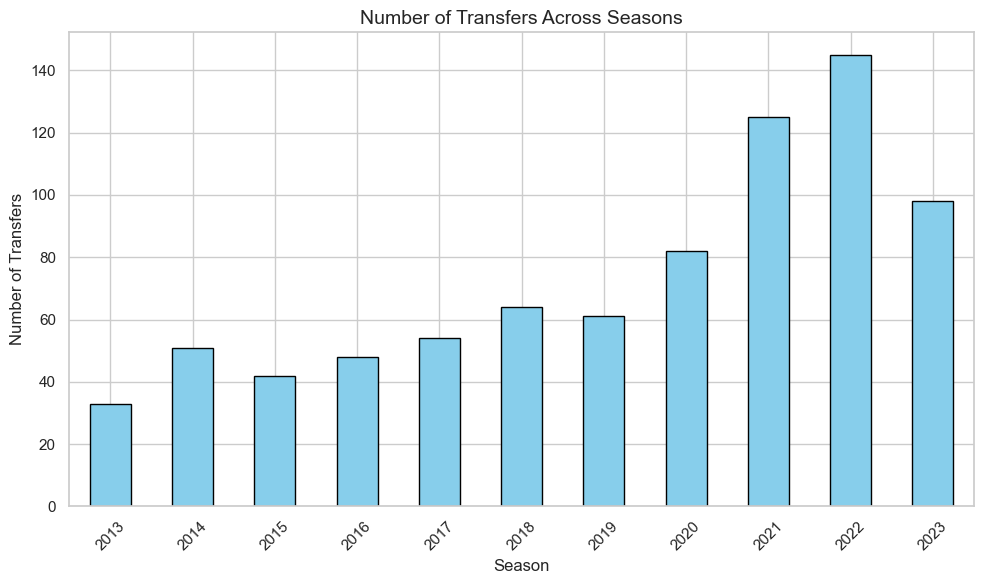

In [28]:
# 1. Number of Transfers Across Seasons
plt.figure(figsize=(10, 6))
season_transfer_count = final_df_new_2.groupby('Season')['transferred'].sum()
season_transfer_count.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Transfers Across Seasons', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Transfers', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\ckuck\AppData\Local\Temp\ipykernel_16092\1696782122.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=transferred_players, x='position', palette='Set2', order=transferred_players['position'].value_counts().index)


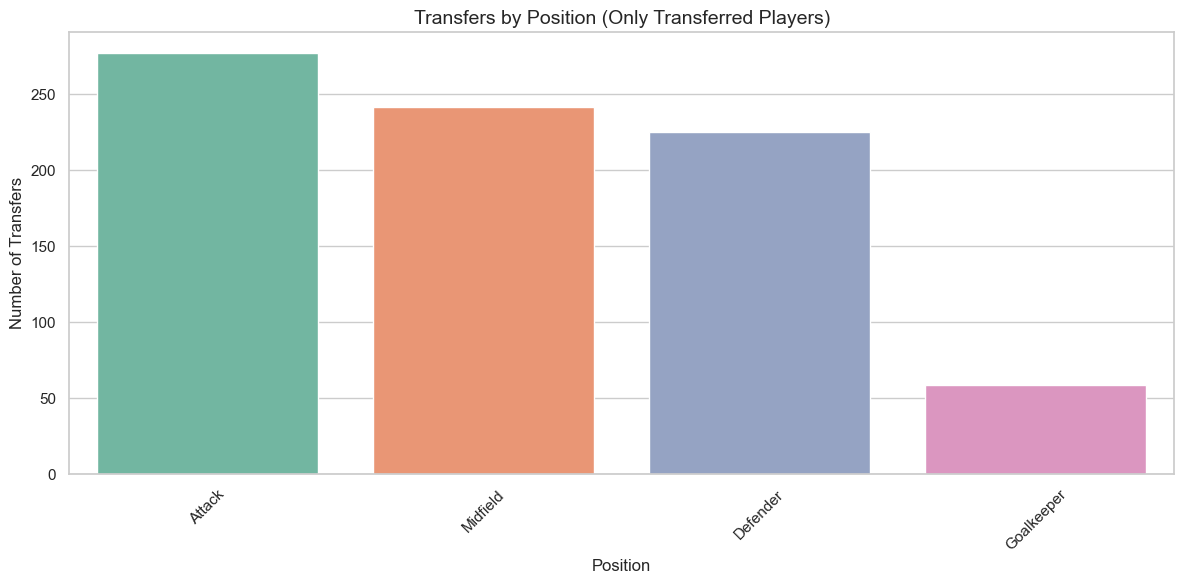

In [29]:
# 2. Transfer by Position (Only Transferred Players)
transferred_players = final_df_new_2[final_df_new_2['transferred'] == 1]

plt.figure(figsize=(12, 6))
sns.countplot(data=transferred_players, x='position', palette='Set2', order=transferred_players['position'].value_counts().index)
plt.title('Transfers by Position (Only Transferred Players)', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Number of Transfers', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


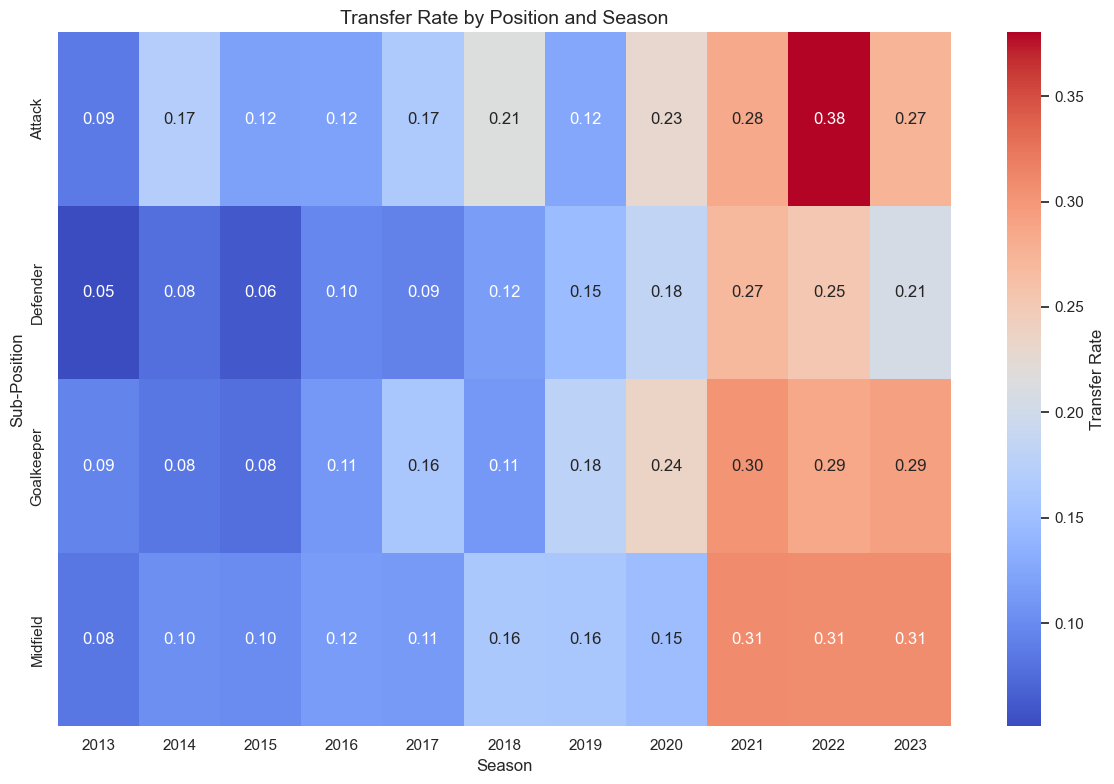

In [30]:
# 3. Transfer by Sub-Position (Heatmap)
position_season_transfer = final_df_new_2.pivot_table(
    index='position', columns='Season', values='transferred', aggfunc='mean'
)
plt.figure(figsize=(12, 8))
sns.heatmap(position_season_transfer, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Transfer Rate'})
plt.title('Transfer Rate by Position and Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Sub-Position', fontsize=12)
plt.tight_layout()
plt.show()

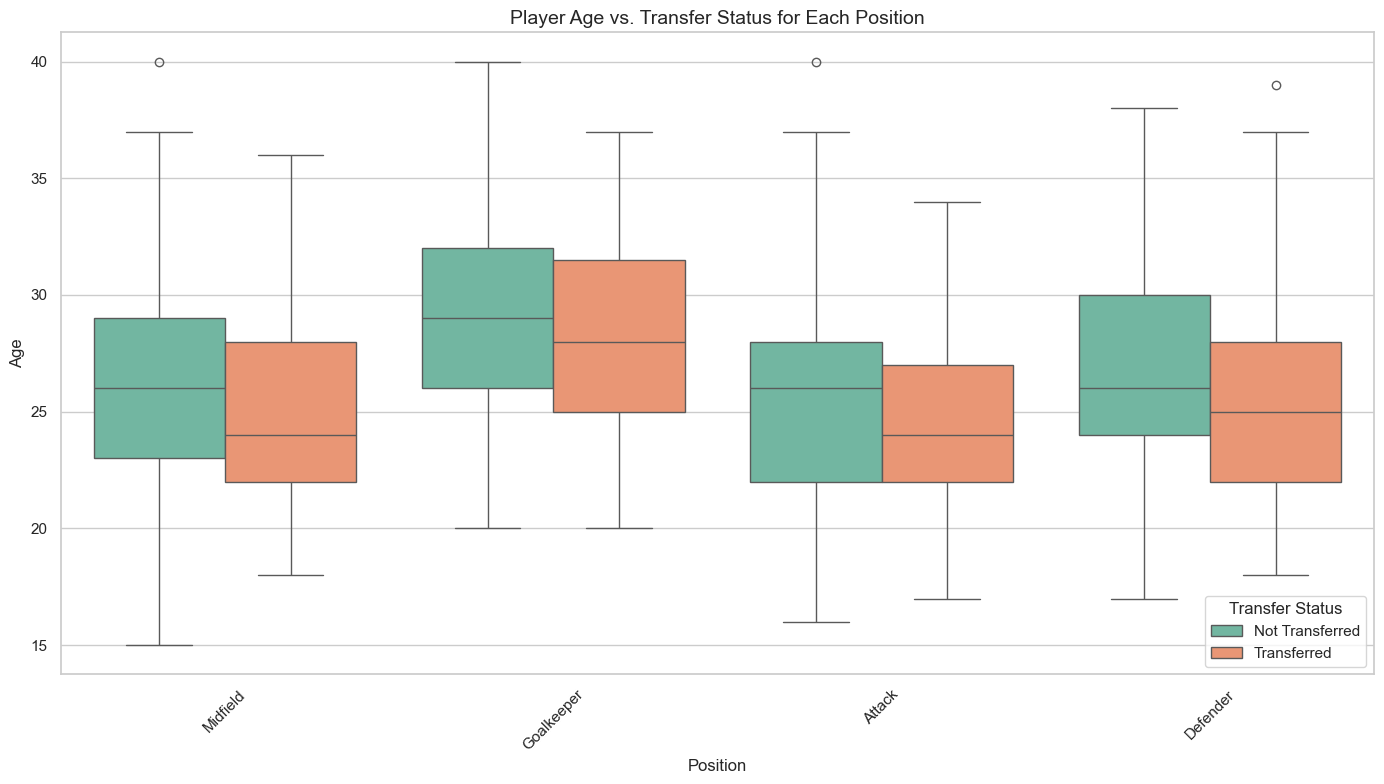

In [31]:
# 4. Player Age vs. Transfer Status for Each Position
plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(data=final_df_new_2, x='position', y='age', hue='transferred', palette='Set2')

# Customize the legend to correctly map colors to labels
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Not Transferred', 'Transferred'], title='Transfer Status')

plt.title('Player Age vs. Transfer Status for Each Position', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


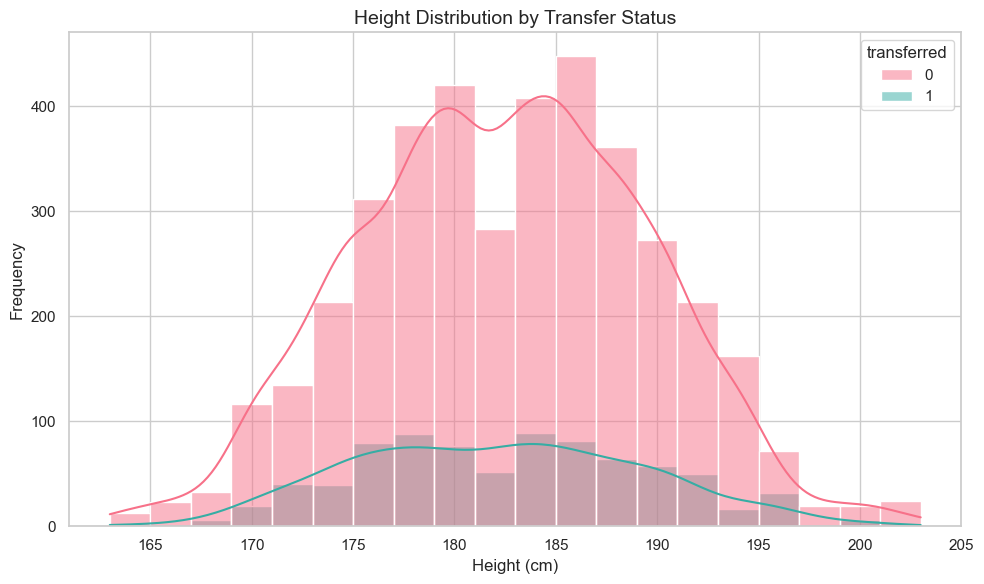

In [32]:
# 5. Height and Transfers
plt.figure(figsize=(10, 6))
sns.histplot(data=final_df_new_2, x='height_in_cm', hue='transferred', kde=True, palette='husl', bins=20)
plt.title('Height Distribution by Transfer Status', fontsize=14)
plt.xlabel('Height (cm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

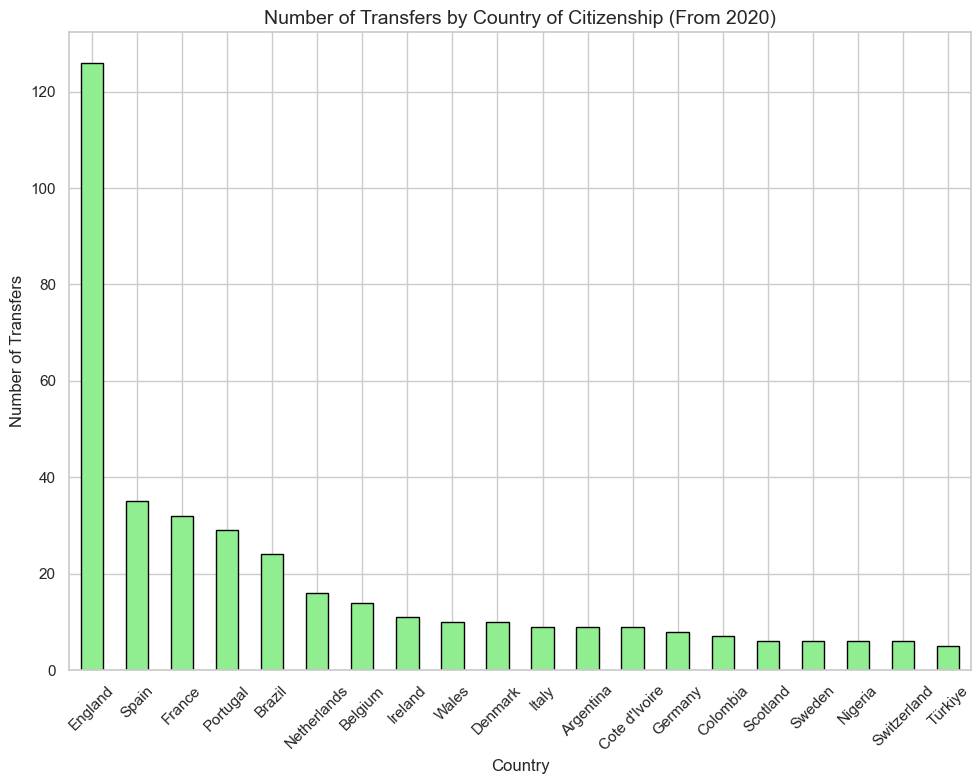

In [33]:
# 6. Country of Citizenship and Transfers (From 2020 Onward)
filtered_data_2020 = final_df_new_2[final_df_new_2['Season'] >= 2020]

plt.figure(figsize=(10, 8))
citizenship_transfer_rate = filtered_data_2020.groupby('country_of_citizenship')['transferred'].sum().sort_values(ascending=False)
citizenship_transfer_rate.head(20).plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Number of Transfers by Country of Citizenship (From 2020)', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Transfers', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


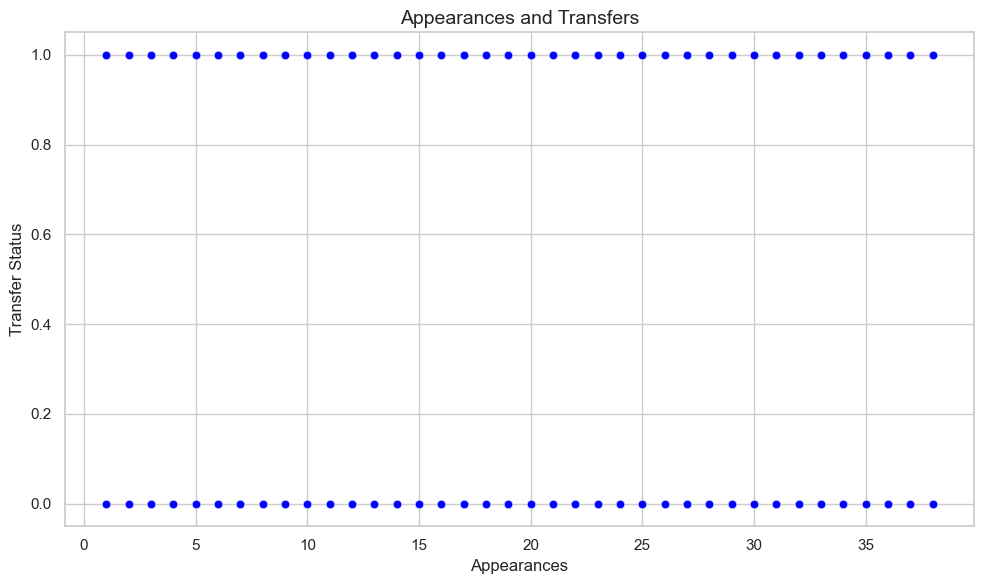

In [34]:
# 7. Appearances and Transfers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df_new_2, x='Appearances', y='transferred', alpha=0.6, color='blue')
plt.title('Appearances and Transfers', fontsize=14)
plt.xlabel('Appearances', fontsize=12)
plt.ylabel('Transfer Status', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\ckuck\AppData\Local\Temp\ipykernel_16092\418304250.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=attacker_data, x='Season', y='Goals', hue='transferred', ci=None, palette='Set1')


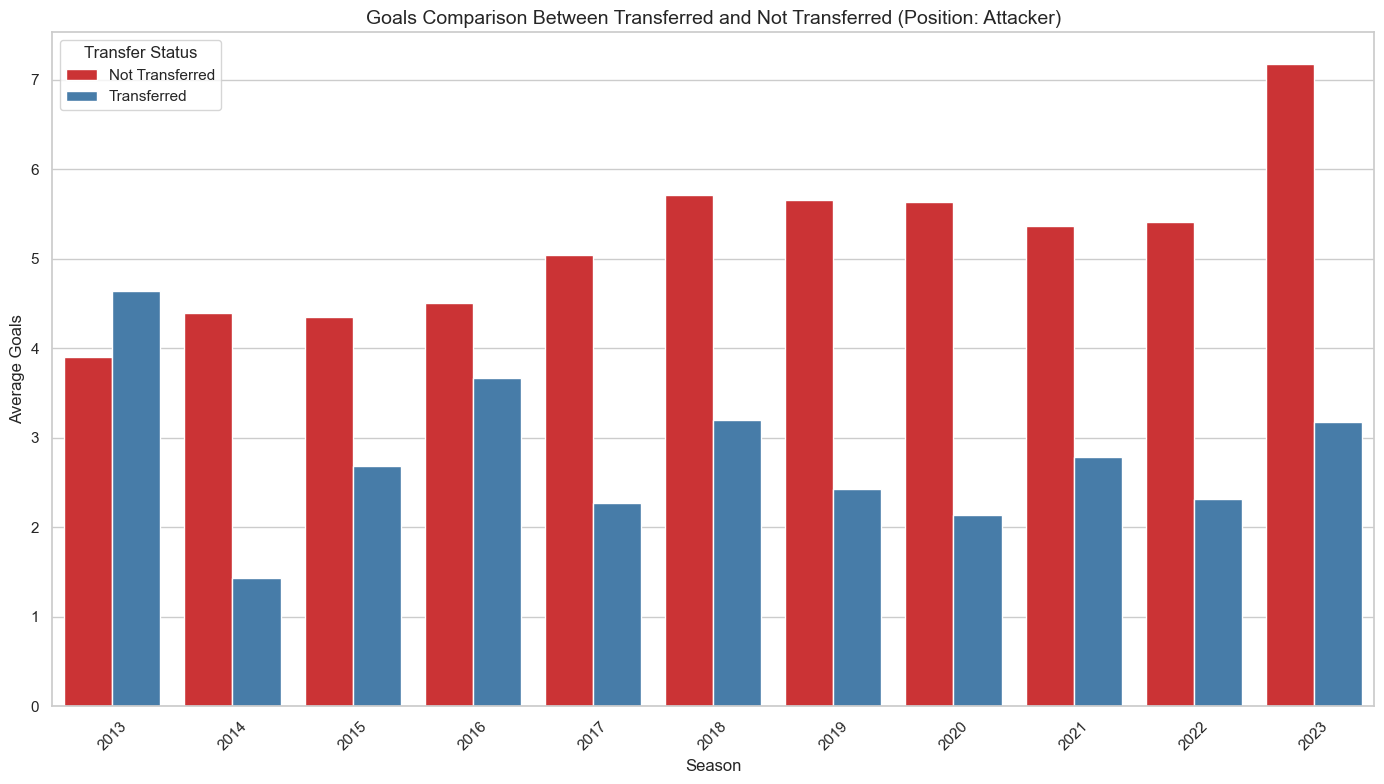

In [35]:
# 8. Goals Comparison Between Transferred and Not Transferred for Position "Attacker" Over Seasons
attacker_data = final_df_new_2[final_df_new_2['position'] == 'Attack']

plt.figure(figsize=(14, 8))
sns.barplot(data=attacker_data, x='Season', y='Goals', hue='transferred', ci=None, palette='Set1')
plt.title('Goals Comparison Between Transferred and Not Transferred (Position: Attacker)', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Goals', fontsize=12)
plt.legend(title='Transfer Status', labels=['Not Transferred', 'Transferred'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


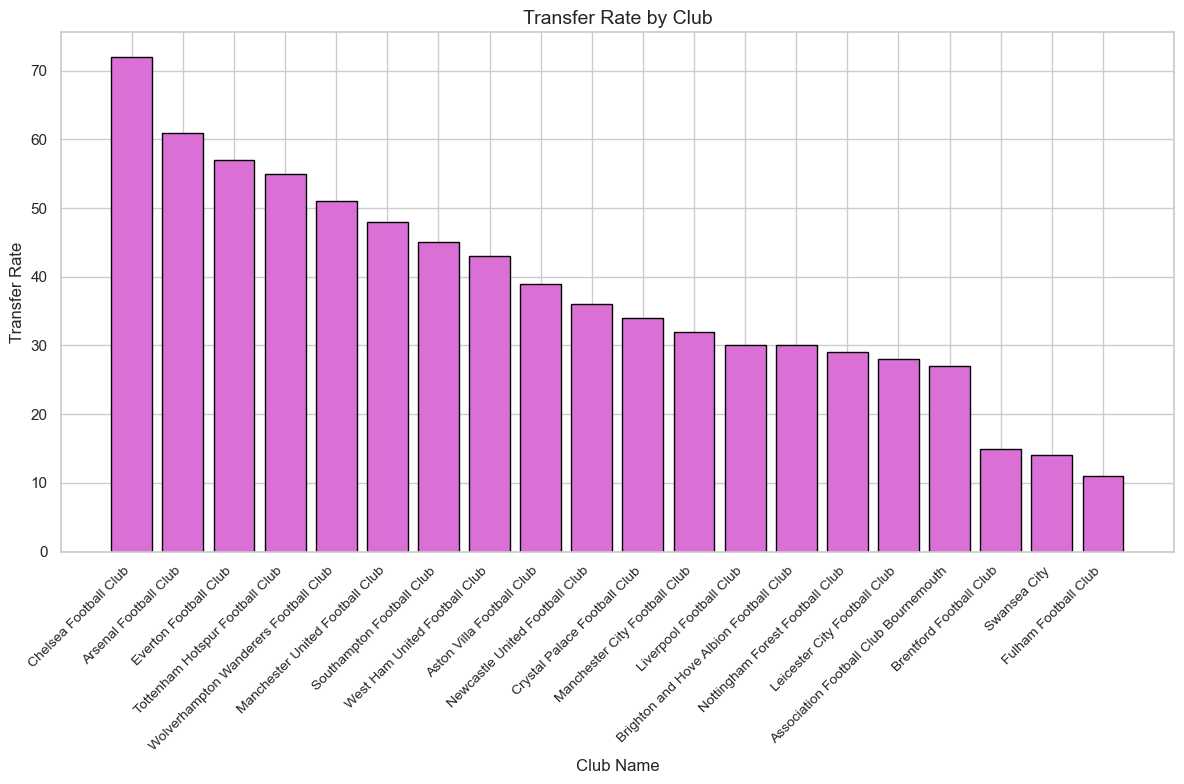

In [36]:
# 9. Transfer Rate by Club with Names
plt.figure(figsize=(12, 8))

# Calculate transfer rates and merge with club names
club_transfer_rate = final_df_new_2.groupby('player_club_id')['transferred'].sum().sort_values(ascending=False)
club_transfer_rate = club_transfer_rate.reset_index().merge(clubs[['club_id', 'name']],
                                             how="inner",
                                             left_on=["player_club_id"],
                                             right_on=["club_id"])
club_transfer_rate = club_transfer_rate.drop(["player_club_id", "club_id"], axis=1)

# Plot the top 20 clubs with the highest transfer rates
top_20_clubs = club_transfer_rate.head(20)
plt.bar(top_20_clubs['name'], top_20_clubs['transferred'], color='orchid', edgecolor='black')
plt.title('Transfer Rate by Club', fontsize=14)
plt.xlabel('Club Name', fontsize=12)
plt.ylabel('Transfer Rate', fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.tight_layout()
plt.show()


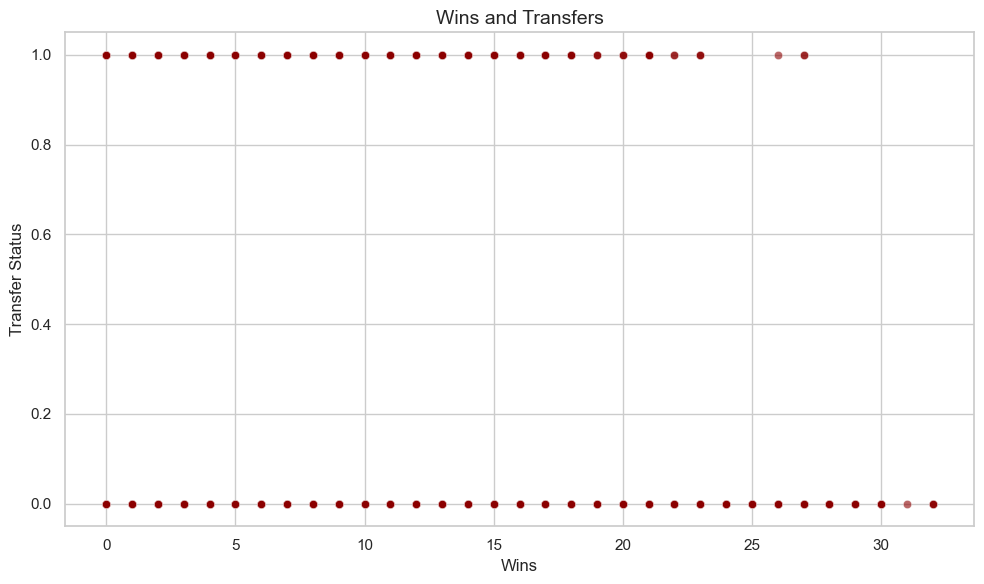

In [37]:
# 10. Wins and Transfers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df_new_2, x='Wins', y='transferred', alpha=0.6, color='darkred')
plt.title('Wins and Transfers', fontsize=14)
plt.xlabel('Wins', fontsize=12)
plt.ylabel('Transfer Status', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\ckuck\AppData\Local\Temp\ipykernel_16092\4079345107.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df_new_2, x='transferred', y='Assists', palette='cool')


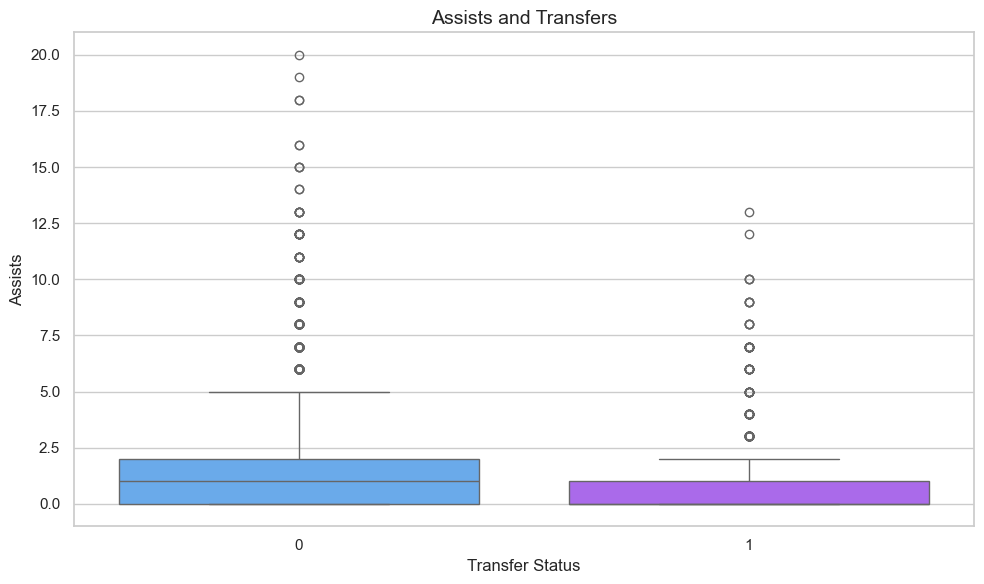

In [38]:
# 11. Assists and Transfers
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df_new_2, x='transferred', y='Assists', palette='cool')
plt.title('Assists and Transfers', fontsize=14)
plt.xlabel('Transfer Status', fontsize=12)
plt.ylabel('Assists', fontsize=12)
plt.tight_layout()
plt.show()

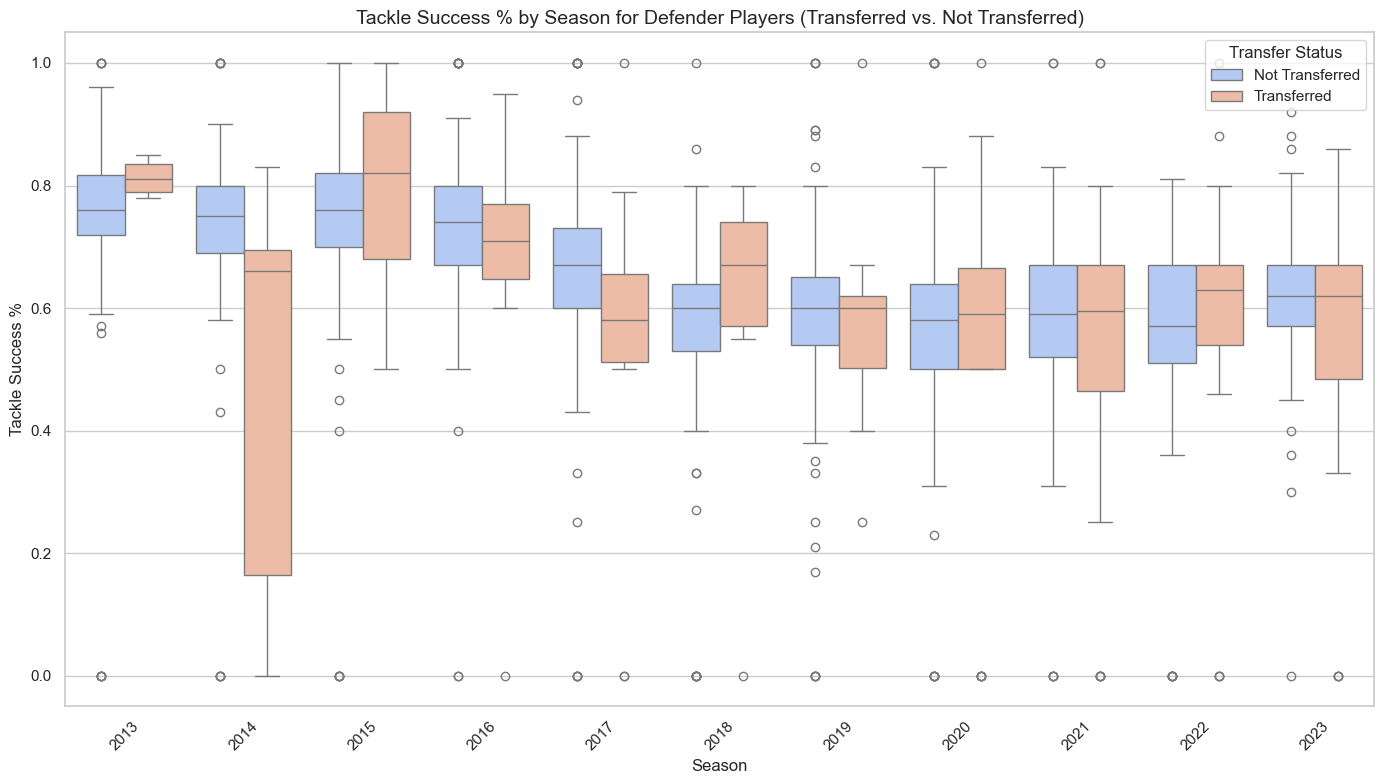

In [39]:
# 12. Tackle Success % by Season for Defender Players

# Filter data for defenders only
defender_players = final_df_new_2[final_df_new_2['position'] == 'Defender']

plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(data=defender_players, x='Season', y='Tackle success %', hue='transferred', palette='coolwarm')

# Customize the legend to ensure proper color-label alignment
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Not Transferred', 'Transferred'], title='Transfer Status')

plt.title('Tackle Success % by Season for Defender Players (Transferred vs. Not Transferred)', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Tackle Success %', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


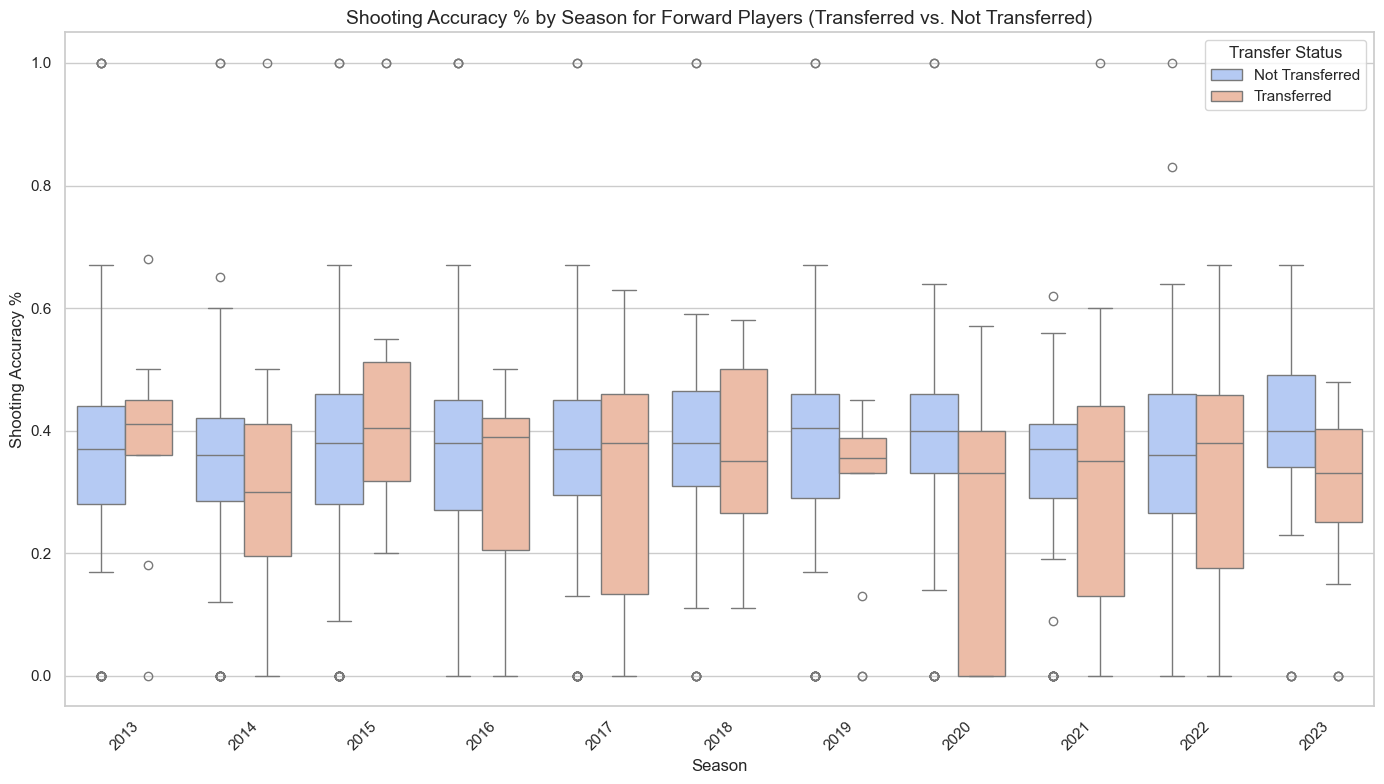

In [40]:
#13. Shooting Accuracy % by Season for Forward Players

# Filter data for forward players only
forward_players = final_df_new_2[final_df_new_2['position'] == 'Attack']

plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(data=forward_players, x='Season', y='Shooting accuracy %', hue='transferred', palette='coolwarm')

# Customize the legend to ensure proper color-label alignment
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Not Transferred', 'Transferred'], title='Transfer Status')

plt.title('Shooting Accuracy % by Season for Forward Players (Transferred vs. Not Transferred)', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Shooting Accuracy %', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\ckuck\AppData\Local\Temp\ipykernel_16092\2571499632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final_df_new_2, x='transferred', y='Penalties scored', palette='Blues')


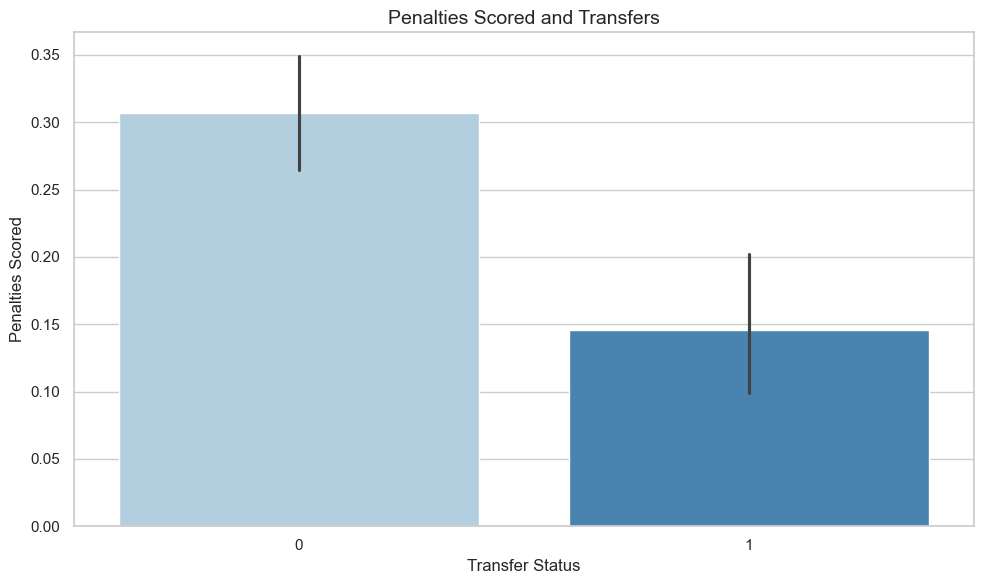

In [41]:
# 14. Penalties and Transfers
plt.figure(figsize=(10, 6))
sns.barplot(data=final_df_new_2, x='transferred', y='Penalties scored', palette='Blues')
plt.title('Penalties Scored and Transfers', fontsize=14)
plt.xlabel('Transfer Status', fontsize=12)
plt.ylabel('Penalties Scored', fontsize=12)
plt.tight_layout()
plt.show()

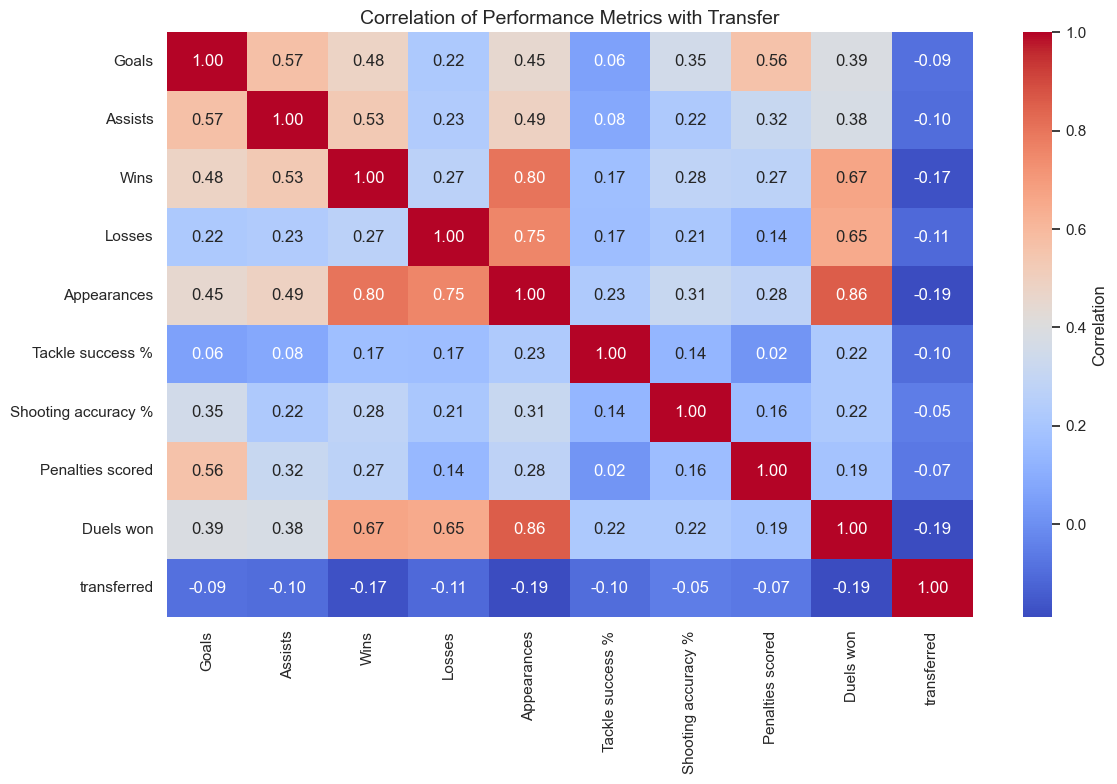

In [42]:
# 15. Performance Metrics Correlation Heatmap
performance_metrics = [
    'Goals', 'Assists', 'Wins', 'Losses', 'Appearances', 'Tackle success %', 
    'Shooting accuracy %', 'Penalties scored', 'Duels won'
]
correlation_data = final_df_new_2[performance_metrics + ['transferred']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation'})
plt.title('Correlation of Performance Metrics with Transfer', fontsize=14)
plt.tight_layout()
plt.show()

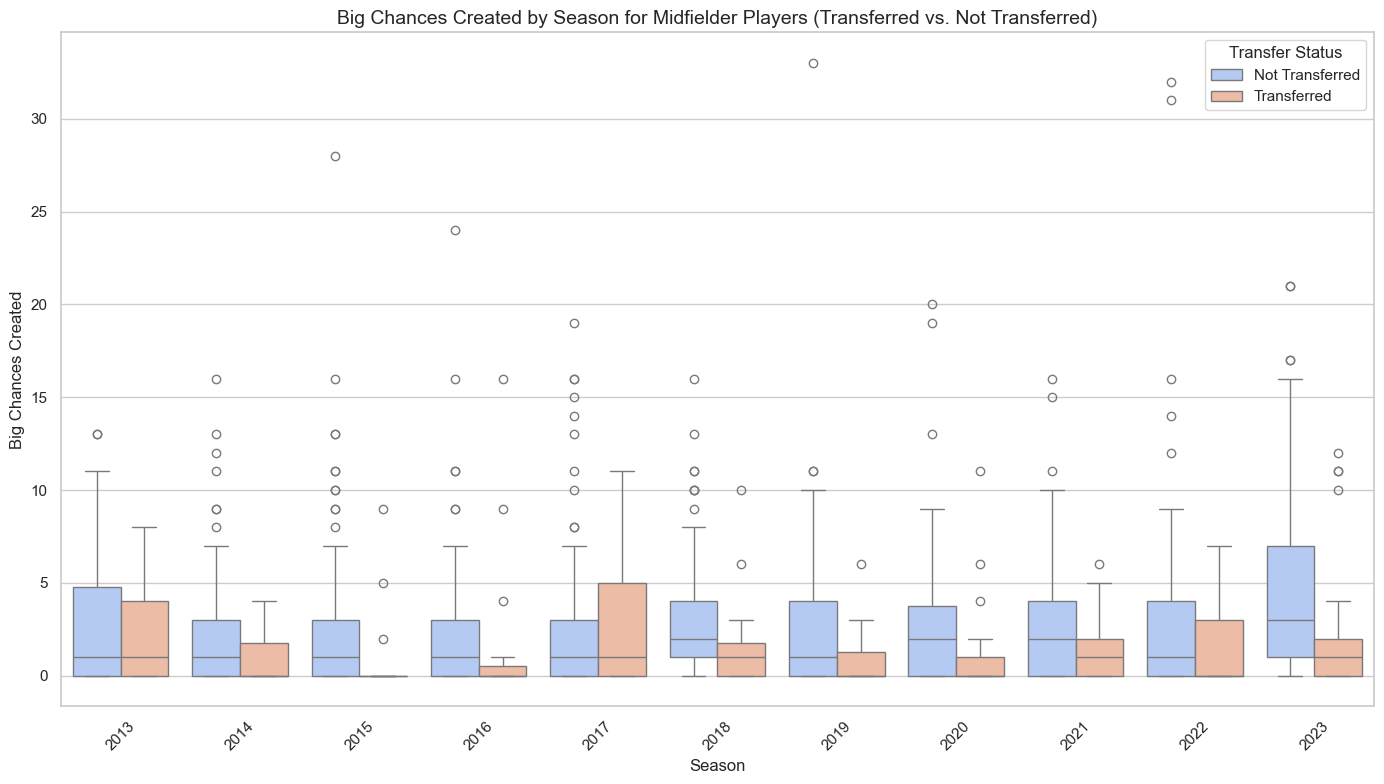

In [43]:
# 16. Big Chances Created by Season for Midfielder Players

# Filter data for midfielders only
midfielder_players = final_df_new_2[final_df_new_2['position'] == 'Midfield']

plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(data=midfielder_players, x='Season', y='Big Chances Created', hue='transferred', palette='coolwarm')

# Customize the legend to ensure proper color-label alignment
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Not Transferred', 'Transferred'], title='Transfer Status')

plt.title('Big Chances Created by Season for Midfielder Players (Transferred vs. Not Transferred)', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Big Chances Created', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [44]:
# 17. Assists and Transfers for Midfielders

# Filter data for midfielders only
midfielder_players = final_df_new_2[final_df_new_2['position'] == 'Midfield']

plt.figure(figsize=(10, 6))
sns.barplot(data=midfielder_players, x='transferred', y='Assists', palette='Blues')
plt.title('Assists and Transfers for Midfielders', fontsize=14)
plt.xlabel('Transfer Status', fontsize=12)
plt.ylabel('Average Assists', fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\ckuck\AppData\Local\Temp\ipykernel_16092\2730136867.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=midfielder_players, x='transferred', y='Assists', palette='Blues')


## Models

In [45]:
categorical_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
features = [
    'country_of_birth','country_of_citizenship','sub_position','position','foot','player_club_id','agent_name',
    
   'best_player_country_of_birth','best_player_country_of_citizenship','best_player_foot',
    'starting_lineup','substitutes',
    'height_in_cm','age','Season','Appearances','Wins',
    'Losses','Last man tackles','Freekicks scored','Yellow cards','Fouls','Shots on target',
    'Sweeper clearances','Assists','Tackle success %','Duels won','Goals with left foot',
    'Accurate long balls','Shots','Penalties Saved','Crosses','Goals with right foot','Shooting accuracy %',
    'Passes','Catches','Passes per match','Headed Clearance','Throw outs','Tackles','Big Chances Created',
    'Hit woodwork','High Claims','Goals per match','Offsides','Goal Kicks','Big chances missed',
    'Blocked shots','Penalties scored','Clean sheets','Own goals','Successful 50/50s','Recoveries',
    'Clearances off line','Goals','Interceptions','Aerial battles won','Cross accuracy %','Punches',
    'Clearances','Errors leading to goal','Duels lost','Aerial battles lost','Goals Conceded',
    'Through balls','Saves','Headed goals','Red cards','num_players_same_position','best_player_height_in_cm','best_player_age',
    'best_player_season','best_player_Appearances','best_player_Wins','best_player_Losses',
    'best_player_Last man tackles','best_player_Freekicks scored','best_player_Yellow cards',
    'best_player_Fouls','best_player_Shots on target','best_player_Sweeper clearances','best_player_Assists',
    'best_player_Tackle success %','best_player_Duels won','best_player_Goals with left foot',
    'best_player_Accurate long balls','best_player_Shots','best_player_Penalties Saved','best_player_Crosses',
    'best_player_Goals with right foot','best_player_Shooting accuracy %','best_player_Passes',
    'best_player_Catches','best_player_Passes per match','best_player_Headed Clearance','best_player_Throw outs',
    'best_player_Tackles','best_player_Big Chances Created','best_player_Hit woodwork','best_player_High Claims',
    'best_player_Goals per match','best_player_Offsides','best_player_Goal Kicks','best_player_Big chances missed',
    'best_player_Blocked shots','best_player_Penalties scored','best_player_Clean sheets','best_player_Own goals',
    'best_player_Successful 50/50s','best_player_Recoveries','best_player_Clearances off line','best_player_Goals',
    'best_player_Interceptions','best_player_Aerial battles won','best_player_Cross accuracy %','best_player_Punches',
    'best_player_Clearances','best_player_Errors leading to goal','best_player_Duels lost','best_player_Aerial battles lost',
    'best_player_Goals Conceded','best_player_Through balls','best_player_Saves','best_player_Headed goals',
    'best_player_Red cards','team_rank_current_season','team_rank_previous_season'
]

X = final_df_new_2[features]
y = final_df_new_2["transferred"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [46]:
#Pipeline preprocessor

# Imputation and preprocessing
numeric_imputer = SimpleImputer(strategy='constant', fill_value=-100)
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

# Define the preprocessor with imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', numeric_imputer),
            ('scaler', StandardScaler())
        ]), list(range(10, 127))), 
        ('cat', Pipeline(steps=[
            ('imputer', categorical_imputer),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)



### Logistic Regression Model

In [47]:

lr_model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42, max_iter=1000)),
    ]
)

# Train the model
lr_model_pipeline.fit(X_train, y_train)

# Evaluate the final model
y_pred = lr_model_pipeline.predict(X_test)
print("Final Test Accuracy:", accuracy_score(y_test, y_pred))
print("Final Test Classification Report:\n", classification_report(y_test, y_pred))


Final Test Accuracy: 0.8257655755015839
Final Test Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       767
           1       0.62      0.22      0.32       180

    accuracy                           0.83       947
   macro avg       0.73      0.59      0.61       947
weighted avg       0.80      0.83      0.79       947



Logistic Regression Final Test Metrics:
Accuracy: 0.8258
Precision: 0.6190
Recall: 0.2167
F1 Score: 0.3210
Weighted F1 Score: 0.7900
ROC-AUC Score: 0.7570

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       767
           1       0.62      0.22      0.32       180

    accuracy                           0.83       947
   macro avg       0.73      0.59      0.61       947
weighted avg       0.80      0.83      0.79       947



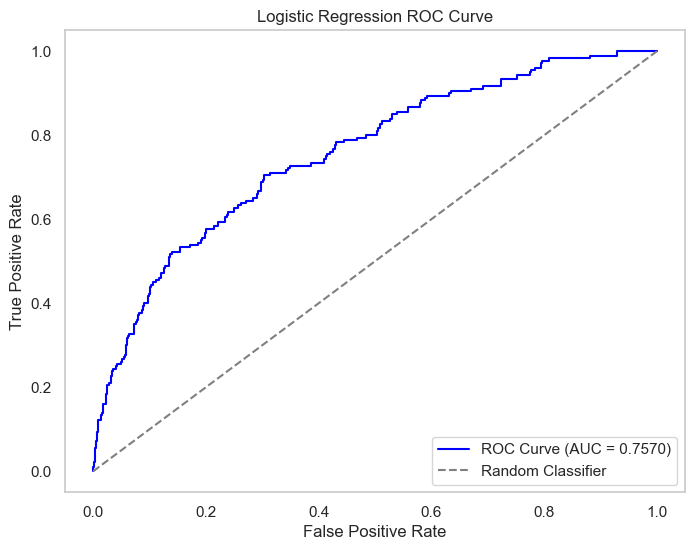

In [48]:
# Evaluate the model
y_pred = lr_model_pipeline.predict(X_test)
y_pred_proba = lr_model_pipeline.predict_proba(X_test)[:, 1]

# Metrics calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average="weighted")
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print("Logistic Regression Final Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Random Forest Model

In [49]:
# Define the Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Define the XGBoost model with hyperparameters
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        ))
    ])

    # Fit the model
    model_pipeline.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = model_pipeline.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Output best hyperparameters
print("Best trial:")
print(study.best_trial)

# Retrieve the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model with best parameters
rf_final_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        **best_params,
        random_state=42
    ))
])
rf_final_model_pipeline.fit(X_train, y_train)

# Evaluate the final model
y_pred = rf_final_model_pipeline.predict(X_test)
print("Final Test Accuracy:", accuracy_score(y_test, y_pred))
print("Final Test Classification Report:\n", classification_report(y_test, y_pred))


[I 2025-01-03 03:36:52,177] A new study created in memory with name: no-name-48dff26e-293b-455e-ae1d-cb0b670457ec
[I 2025-01-03 03:37:14,777] Trial 0 finished with value: 0.8426610348468849 and parameters: {'n_estimators': 163, 'max_depth': 20, 'max_features': 0.2437537673285819, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8426610348468849.
[I 2025-01-03 03:37:41,431] Trial 1 finished with value: 0.8236536430834214 and parameters: {'n_estimators': 496, 'max_depth': 14, 'max_features': 0.11521964727105305, 'min_samples_split': 18, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8426610348468849.
[I 2025-01-03 03:37:52,263] Trial 2 finished with value: 0.8194297782470961 and parameters: {'n_estimators': 232, 'max_depth': 6, 'max_features': 0.2617945099389204, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8426610348468849.
[I 2025-01-03 03:39:14,304] Trial 3 finished with value: 0.8268215417106652 and parameters: {'n_

Best trial:
FrozenTrial(number=74, state=TrialState.COMPLETE, values=[0.8447729672650475], datetime_start=datetime.datetime(2025, 1, 3, 4, 30, 26, 907883), datetime_complete=datetime.datetime(2025, 1, 3, 4, 30, 46, 543258), params={'n_estimators': 254, 'max_depth': 19, 'max_features': 0.123571265227104, 'min_samples_split': 2, 'min_samples_leaf': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=20, log=False, low=5, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=74, value=None)
Best Parameters: {'n_estimators': 254, 'max_depth': 19, 'max_features': 0.123571265227104, 'min_samples_split': 2, 'min_samples_leaf': 2}
Final Test Accuracy: 0.8447729672650475
Final Test Clas

Random Forest Final Test Metrics:
Accuracy: 0.8448
Precision: 0.8511
Recall: 0.2222
F1 Score: 0.3524
Weighted F1 Score: 0.8055
ROC-AUC Score: 0.7715


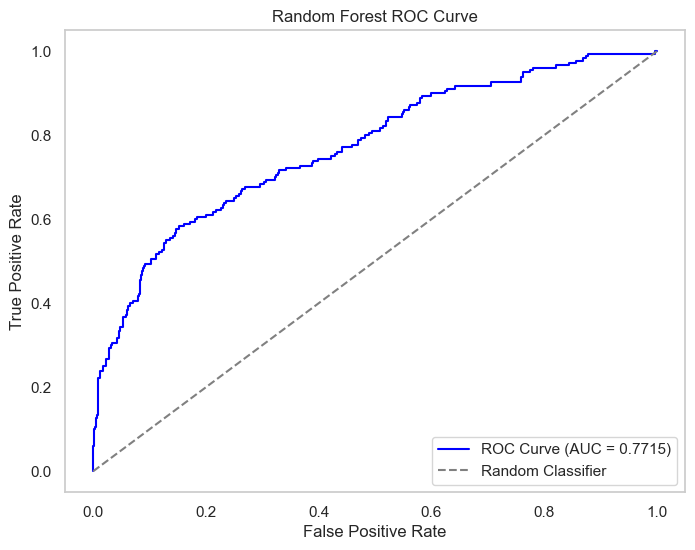

In [50]:


# Evaluate the final model
y_pred_proba = rf_final_model_pipeline.predict_proba(X_test)[:, 1]  # Probability predictions for ROC-AUC
y_pred = rf_final_model_pipeline.predict(X_test)  # Binary predictions

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print("Random Forest Final Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


### XGBoost Model

In [51]:

# Define the Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.4, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 300)

    # Define the XGBoost model with hyperparameters
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            min_child_weight=min_child_weight,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        ))
    ])

    # Fit the model
    model_pipeline.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = model_pipeline.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Output best hyperparameters
print("Best trial:")
print(study.best_trial)

# Retrieve the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model with best parameters
final_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        **best_params,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])
final_model_pipeline.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model_pipeline.predict(X_test)
print("Final Test Accuracy:", accuracy_score(y_test, y_pred))
print("Final Test Classification Report:\n", classification_report(y_test, y_pred))


[I 2025-01-03 04:43:02,860] A new study created in memory with name: no-name-45377601-76b3-4292-a428-e0596547da6e
C:\ProgramData\anaconda3\envs\MS_Dissertation\lib\site-packages\xgboost\core.py:158: UserWarning: [04:43:02] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-01-03 04:43:07,194] Trial 0 finished with value: 0.7856388595564942 and parameters: {'n_estimators': 288, 'max_depth': 20, 'learning_rate': 0.06522229203472014, 'subsample': 0.6077043965256108, 'colsample_bytree': 0.9624432132798053, 'min_child_weight': 3, 'scale_pos_weight': 235}. Best is trial 0 with value: 0.7856388595564942.
C:\ProgramData\anaconda3\envs\MS_Dissertation\lib\site-packages\xgboost\core.py:158: UserWarning: [04:43:07] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.war

Best trial:
FrozenTrial(number=93, state=TrialState.COMPLETE, values=[0.8542766631467793], datetime_start=datetime.datetime(2025, 1, 3, 4, 47, 17, 859322), datetime_complete=datetime.datetime(2025, 1, 3, 4, 47, 21, 329431), params={'n_estimators': 281, 'max_depth': 18, 'learning_rate': 0.03175825961915575, 'subsample': 0.8374014691082539, 'colsample_bytree': 0.9943806533212323, 'min_child_weight': 3, 'scale_pos_weight': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=20, log=False, low=5, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'scale_pos_weight': IntDistribution(high=300, log=False, low=1

In [52]:

# Evaluate the final model
y_pred = final_model_pipeline.predict(X_test)
y_pred_proba = final_model_pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print("Final Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


Final Test Metrics:
Accuracy: 0.8543
Precision: 0.8000
Recall: 0.3111
F1 Score: 0.4480
Weighted F1 Score: 0.8271
ROC-AUC Score: 0.7755


### Neural Network Model

In [53]:
# Create a Neural Network model
nn_model = Sequential()
nn_model.add(Dense(512, activation='relu', input_dim=preprocessor.fit_transform(X_train).shape[1]))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.5))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Train the Neural Network model
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

X_train_transformed = preprocessor.fit_transform(X_train).toarray()
nn_model.fit(X_train_transformed, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stop], class_weight={0: 1, 1: 3})

# Evaluate the Neural Network model
y_pred_nn = (nn_model.predict(preprocessor.transform(X_test)) > 0.5).astype(int).flatten()

print("Neural Network Test Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Neural Network Classification Report:\n", classification_report(y_test, y_pred_nn))


Epoch 1/100
48/48 [==============================] - 3s 17ms/step - loss: 1.1268 - accuracy: 0.5327 - val_loss: 0.6586 - val_accuracy: 0.5923
Epoch 2/100
48/48 [==============================] - 0s 9ms/step - loss: 0.9355 - accuracy: 0.6126 - val_loss: 0.7010 - val_accuracy: 0.4960
Epoch 3/100
48/48 [==============================] - 0s 9ms/step - loss: 0.9225 - accuracy: 0.6371 - val_loss: 0.6913 - val_accuracy: 0.5409
Epoch 4/100
48/48 [==============================] - 0s 9ms/step - loss: 0.8588 - accuracy: 0.6863 - val_loss: 0.6448 - val_accuracy: 0.6293
Epoch 5/100
48/48 [==============================] - 0s 9ms/step - loss: 0.8110 - accuracy: 0.7097 - val_loss: 0.6183 - val_accuracy: 0.6662
Epoch 6/100
48/48 [==============================] - 0s 9ms/step - loss: 0.8063 - accuracy: 0.7153 - val_loss: 0.5655 - val_accuracy: 0.7190
Epoch 7/100
48/48 [==============================] - 0s 9ms/step - loss: 0.7716 - accuracy: 0.7427 - val_loss: 0.5643 - val_accuracy: 0.7071
Epoch 8/100


30/30 [==============================] - 0s 4ms/step
Neural Network Final Test Metrics:
Accuracy: 0.7645
Precision: 0.4085
Recall: 0.5333
F1 Score: 0.4627
Weighted F1 Score: 0.7757
ROC-AUC Score: 0.7524


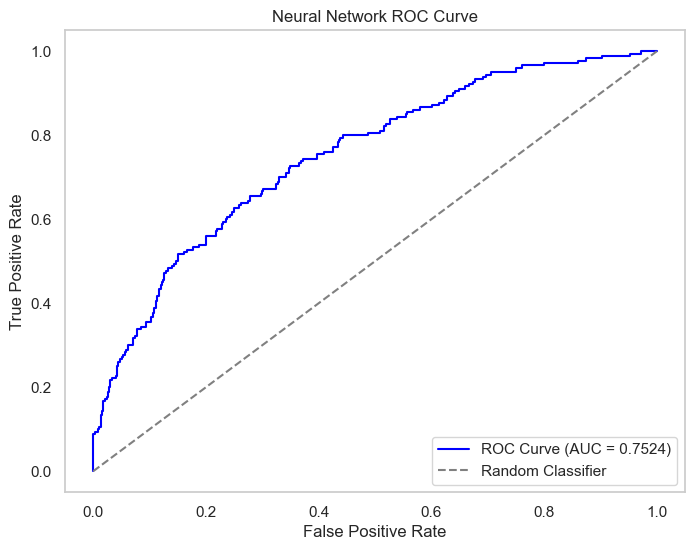

In [54]:
# Evaluate the Neural Network model
y_pred_proba_nn = nn_model.predict(preprocessor.transform(X_test)).flatten()  # Probability predictions
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)  # Binary predictions

# Calculate metrics
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn, average='binary')
recall_nn = recall_score(y_test, y_pred_nn, average='binary')
f1_nn = f1_score(y_test, y_pred_nn, average='binary')
weighted_f1_nn = f1_score(y_test, y_pred_nn, average='weighted')
roc_auc_nn = roc_auc_score(y_test, y_pred_proba_nn)

# Print metrics
print("Neural Network Final Test Metrics:")
print(f"Accuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1 Score: {f1_nn:.4f}")
print(f"Weighted F1 Score: {weighted_f1_nn:.4f}")
print(f"ROC-AUC Score: {roc_auc_nn:.4f}")

# Plot ROC Curve
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, color='blue', label=f'ROC Curve (AUC = {roc_auc_nn:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [55]:
# Logistic Regression
y_pred_proba_lr = lr_model_pipeline.predict_proba(X_test)[:, 1]
y_pred_lr = lr_model_pipeline.predict(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

# Random Forest
y_pred_proba_rf = rf_final_model_pipeline.predict_proba(X_test)[:, 1]
y_pred_rf = rf_final_model_pipeline.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# XGBoost
y_pred_proba_xgb = final_model_pipeline.predict_proba(X_test)[:, 1]
y_pred_xgb = final_model_pipeline.predict(X_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

# Neural Network
y_pred_proba_nn = nn_model.predict(preprocessor.transform(X_test)).flatten()
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)
roc_auc_nn = roc_auc_score(y_test, y_pred_proba_nn)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})")
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {roc_auc_nn:.4f})")

# Add diagonal line for reference
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier")

# Customize the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()


30/30 [==============================] - 0s 4ms/step
